## Mô tả chức năng:

Nhận dạng và đọc biển số xe bằng OpenCV và CNN

## Nhận dạng vị trí biển số từ ảnh

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# import necessary package
import cv2
import imutils
import numpy as np
# from cv2 import imshow
from google.colab.patches import cv2_imshow

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

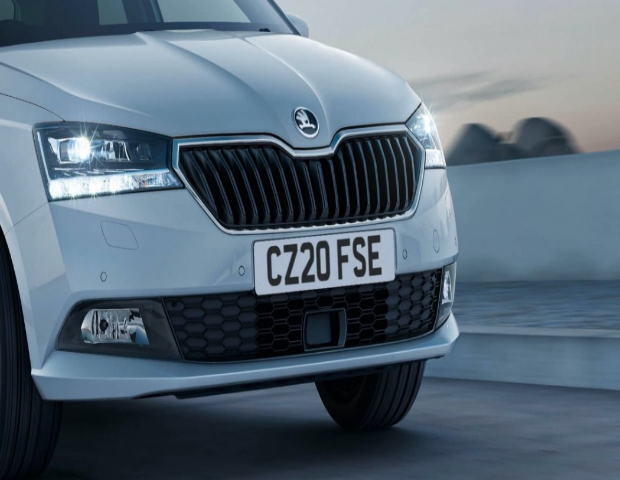

In [ ]:
# load hình ảnh 
image_path = '/gdrive/MyDrive/artificial_intelligent/car.png'
image = cv2.imread(image_path)
image = cv2.resize(image,(620,480))
cv2_imshow(image)

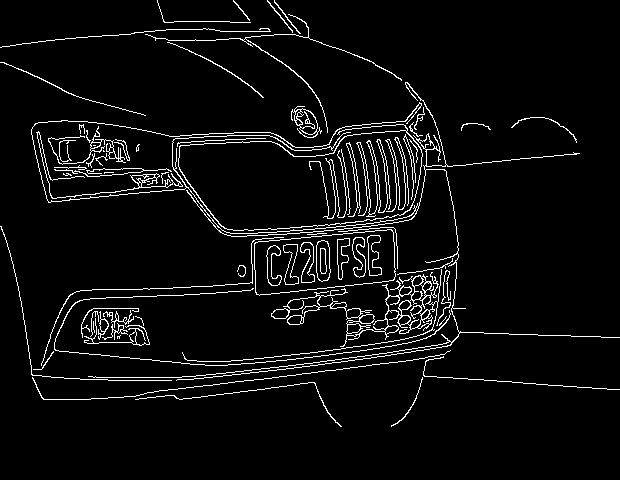

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray,(3,3),0)
# blurred = cv2.bilateralFilter(gray, 13, 15, 15)
edged = cv2.Canny(blurred,30,200)
cv2_imshow(edged)

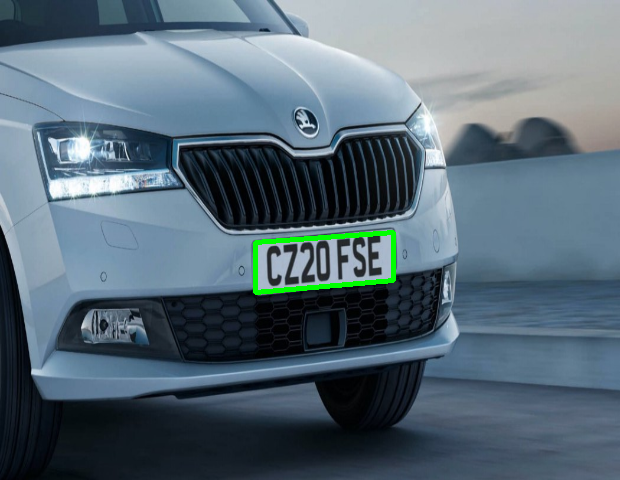

In [ ]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
screenCnt = None
img_cnt = image.copy()
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c,0.02*peri, True)
    area = cv2.contourArea(c)

    if len(approx) == 4: #and area <10000:
        screenCnt = approx
        cv2.drawContours(img_cnt,[screenCnt],0,(0,255,0),3)
        break

cv2_imshow(img_cnt)

In [ ]:
mask = np.zeros_like(gray, np.uint8)
cv2.drawContours(mask,[screenCnt],0,255,-1)
cv2.bitwise_and(image,image,mask=mask)

(x,y) = np.where(mask == 255)
(topX, topY) = (np.min(x), np.min(y))
(botX, botY) = (np.max(x), np.max(y))

# cropped = blurred[topX:botX+1, topY: botY+1]
# roi = cv2.threshold(cropped,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
plate = image[topX:botX+1, topY: botY+1]

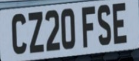

In [ ]:
cv2_imshow(plate)

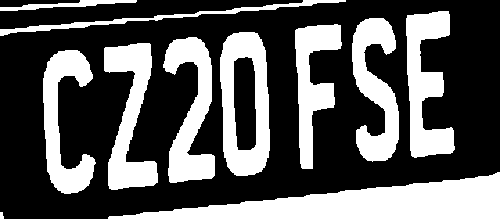

In [ ]:
plate = imutils.resize(plate,width=500)
gray_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
blurred_plate = cv2.GaussianBlur(gray_plate,(3,3),0)

thresh = cv2.threshold(blurred_plate,100,255,cv2.THRESH_BINARY_INV)[1]
cv2_imshow(thresh)

In [ ]:
# sort cnts left to right
def sort_contours(cnts):
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][0], reverse=False))
    return (cnts,boundingBoxes)

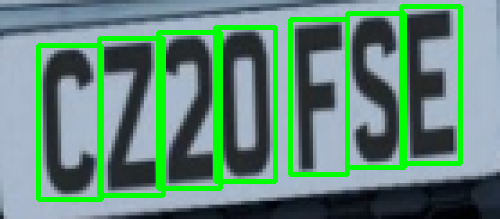

In [ ]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts,boundingBoxes = sort_contours(cnts)
clone_plate = plate.copy()

boundingBoxesChar =[]

for b in boundingBoxes:
    (x,y,w,h) = b
    if w > 10 and w< 200 and h >70 and h <300:
        boundingBoxesChar.append(b)
        cv2.rectangle(clone_plate,(x-5,y-5),(x+w+5,y+h+5),(0,255,0),3)

cv2_imshow(clone_plate)

In [ ]:
print(len(boundingBoxesChar))

7


## Train CNN model nhận diện kí tự

In [ ]:
from imutils import paths
import os 
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class LoadnPreprocess:
    def __init__(self, width,height):
        self.width = width
        self.height = height
    
    def load(self,paths,verbose = -1):
        data = []
        labels = []
        for (i,p) in enumerate(paths):
            image = cv2.imread(p)
            lb = p.split(os.path.sep)[-2]

            image = cv2.resize(image,(self.width,self.height),interpolation=cv2.INTER_AREA)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = img_to_array(image)

            data.append(image)
            labels.append(lb)

            if verbose > 0 and i > 0 and (i+1)%verbose ==0:
                print(f'Preprocessed {i+1} Label: {lb}')
        return (np.array(data), np.array(labels))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class LeNet:
    @staticmethod
    # Achitecture Lenet: INPUT => CONV => ACT => POOL => CONV => ACT => POOL => FC => ACT => FC
    def build(width,height,depth,classes):
        model = Sequential()
        inputShape = (height,width,depth)

        if K.image_data_format() == 'channels_first':
            inputShape = (depth,height,width)

        # first set of CONV  => RELU => POOL layers
        model.add(Conv2D(20,(5,5), padding='same', input_shape = inputShape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        #second set of CONV => RELU => POOL layers
        model.add(Conv2D(50,(5,5), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        #first set of FC => RELU
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))

        #softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))

        return model

In [ ]:
pathDS = '/gdrive/MyDrive/artificial_intelligent/Car_letter_Dataset/CNN_letter_Dataset'
images = list(paths.list_images(pathDS))
lnp = LoadnPreprocess(32,32)
x,y = lnp.load(images,500)

Preprocessed 500 Label: U
Preprocessed 1000 Label: Z
Preprocessed 1500 Label: Y
Preprocessed 2000 Label: Y
Preprocessed 2500 Label: X
Preprocessed 3000 Label: X
Preprocessed 3500 Label: V
Preprocessed 4000 Label: N
Preprocessed 4500 Label: J
Preprocessed 5000 Label: I
Preprocessed 5500 Label: I
Preprocessed 6000 Label: E
Preprocessed 6500 Label: B
Preprocessed 7000 Label: 7
Preprocessed 7500 Label: 5
Preprocessed 8000 Label: 5
Preprocessed 8500 Label: 2


In [ ]:
print(x.shape)
print(y.shape)

(8790, 32, 32, 1)
(8790,)


In [ ]:
x = x.astype('float') /255.0

In [ ]:
labels = np.unique(y)
labels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

In [ ]:
labels = list(labels)
num_labels = len(labels)
num_labels

35

In [ ]:
train_val_X,testX,train_val_Y,testY = train_test_split(x,y,test_size=0.25,random_state=102)
trainX,valX,trainY,valY = train_test_split(train_val_X,train_val_Y)

In [ ]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
valY = lb.fit_transform(valY)
testY = lb.fit_transform(testY)

In [ ]:
model = LeNet.build(32,32,1,num_labels)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 20)        520       
                                                                 
 activation (Activation)     (None, 32, 32, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 16, 16, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 50)         0         
 2D)                                                    

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
H = model.fit(trainX,trainY, validation_data=(valX,valY), batch_size=128, epochs=100, verbose=1)

Epoch 1/100
39/39 [==============================] - 8s 17ms/step - loss: 2.3328 - accuracy: 0.4049 - val_loss: 1.0748 - val_accuracy: 0.7081
Epoch 2/100
39/39 [==============================] - 0s 7ms/step - loss: 0.5522 - accuracy: 0.8414 - val_loss: 0.3003 - val_accuracy: 0.9041
Epoch 3/100
39/39 [==============================] - 0s 7ms/step - loss: 0.1865 - accuracy: 0.9488 - val_loss: 0.1452 - val_accuracy: 0.9539
Epoch 4/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0841 - accuracy: 0.9802 - val_loss: 0.0939 - val_accuracy: 0.9751
Epoch 5/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0554 - accuracy: 0.9871 - val_loss: 0.0689 - val_accuracy: 0.9800
Epoch 6/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0346 - accuracy: 0.9919 - val_loss: 0.0434 - val_accuracy: 0.9860
Epoch 7/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0254 - accuracy: 0.9937 - val_loss: 0.0537 - val_accuracy: 0.9854
Epoch 8/100


In [ ]:
print('Accuracy model: ',model.evaluate(testX,testY)[1])

69/69 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9959
Accuracy model:  0.995905339717865


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), 
                            target_names=[str(x) for x in lb.classes_]))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      0.92      0.96        24
           2       1.00      1.00      1.00        28
           3       1.00      0.97      0.99        36
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00        29
           7       1.00      1.00      1.00        35
           8       1.00      0.91      0.95        33
           9       1.00      1.00      1.00        30
           A       1.00      1.00      1.00        38
           B       1.00      1.00      1.00        39
           C       1.00      1.00      1.00        32
           D       1.00      1.00      1.00        40
           E       1.00      1.00      1.00        32
           F       1.00      1.00      1.00        30
           G       1.00     

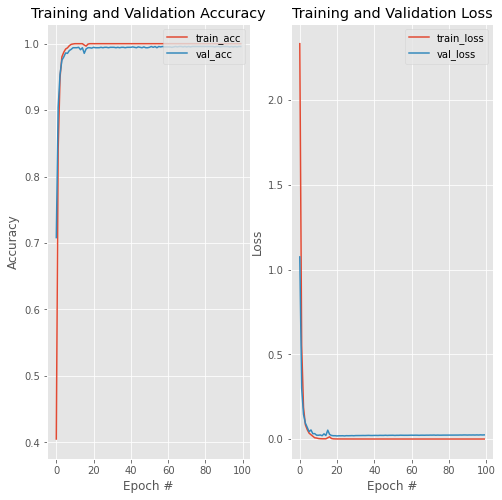

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

1/1 [==============================] - 0s 13ms/step


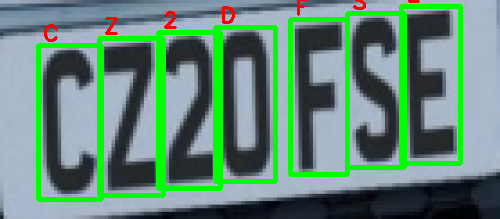

In [ ]:
plate2 = plate.copy()
num_plate =[]

for (i,b) in enumerate(boundingBoxesChar):
    (x,y,w,h) = b
    cropped = plate[y-10:y+h+10,x-10:x+w+10]
    cropped = cv2.resize(cropped,(32,32))
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    cropped = img_to_array(cropped)
    cropped = np.expand_dims(cropped,axis=0)
    pred = model.predict(cropped).argmax(axis=1)
    char = labels[pred[0]]
    num_plate.append(char)
    cv2.rectangle(plate2,(x-5,y-5),(x+w+5,y+h+5),(0,255,0),3)
    cv2.putText(plate2,char,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)

cv2_imshow(plate2)

In [ ]:
print('Number plate recognized: '+ ''.join(num_plate))

Number plate recognized: CZ2DFSE


In [ ]:
model.save('model.hdf5')  # creates a HDF5 file 'my_model.h5'